In [1]:
import gym
import gym_anytrading

from gym_anytrading.envs import TradingEnv, ForexEnv, StocksEnv, Actions, Positions 
from gym_anytrading.datasets import FOREX_EURUSD_1H_ASK, STOCKS_GOOGL
import matplotlib.pyplot as plt
from keras import applications
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Flatten, Dropout, Input, Concatenate, Conv2D
from keras.optimizers import Adam

from rl.agents.dqn import DQNAgent
from rl.agents.ddpg import DDPGAgent
from rl.policy import BoltzmannQPolicy, EpsGreedyQPolicy
from rl.memory import SequentialMemory
from rl.core import Processor
from rl.random import OrnsteinUhlenbeckProcess
from rl.callbacks import FileLogger, ModelIntervalCheckpoint, TrainIntervalLogger

from sklearn import preprocessing
import warnings
warnings.filterwarnings('ignore')

import json
import numpy as np

Using TensorFlow backend.
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\py

In [2]:
class EnvProcessor(Processor):
    def process_observation(self, observation):
        assert observation.ndim == 2  # (height, width, channel)
        return self.process_obs_1(observation)
    
    def process_obs_1(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1])
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        diff = preprocessing.normalize([diff], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
    
    def process_obs_2(self, observation):
        prices = []
        diff = []
        for o in observation:
            prices.append(o[0])
            diff.append(o[1] / o[0] * 100)
        prices = preprocessing.normalize([prices], norm='l2', axis=1, copy=True, return_norm=False)[0]
        new_obs = np.column_stack((prices, diff))
        return new_obs
        
    def process_state_batch(self, batch):
#         print(batch)
        return batch

    def process_reward(self, reward):
        return reward

In [3]:
def env_creator():
    return gym.make('forex-v0', frame_bound=(50, 2500), window_size=10)

env = env_creator()
nb_actions = env.action_space.n

# Next, we build a very simple model.
model = Sequential()
model.add(Conv2D(input_shape=(1,) + env.observation_space.shape, filters=32, kernel_size=(4,2), padding='same'))
model.add(Conv2D(filters=64, kernel_size=(4,2), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
model.add(Conv2D(filters=128, kernel_size=(4,2), padding='same'))
model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(nb_actions, activation='linear'))
print(model.summary())

def agent_creator():
    processor = EnvProcessor()
    memory = SequentialMemory(limit=100000, window_length=1)
    # policy = CustomEpsGreedyQPolicy(update_interval = 2500, eps = 1.0)
    policy = BoltzmannQPolicy()
    agent = DQNAgent(model=model, nb_actions=nb_actions, memory=memory, nb_steps_warmup=20,
                   target_model_update=1e-2, policy=policy, batch_size=64, processor=processor, 
                   train_interval=32, enable_double_dqn=True)
    agent.compile(Adam(lr=1e-3), metrics=['mae'])
    return agent

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 1, 10, 32)         544       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 1, 10, 64)         16448     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 10, 128)        65664     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 10, 128)        131200    
_________________________________________________________________
flatten_1 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dens

In [4]:
from evaluator import Evaluator

e = Evaluator(agent_creator, env_creator, name="dqn")
e.train(repeat=1)

['loss', 'mean_absolute_error', 'mean_q']
starting train 1
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
 32/489 [>.............................] - ETA: 9s - reward: 2.8969 - cumulative_reward: 55.4656 WARNING:tensorflow:From d:\tech\mtech\sls\project2\env\lib\site-packages\tensorflow\python\ops\math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.
489/489 [============================>.] - ETA: 0s - reward: -15.2125 - cumulative_reward: 100.3927
train 1 completed. total_reward: 189.79999999994675 total_profile: 0.8547702579960371
min reward: -147.20000000000067, max reward: 79.40000000000057, mean_reward: 0.07750102082480471



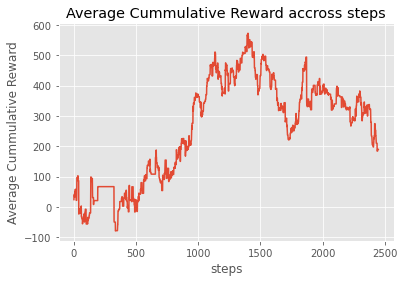

In [5]:
e.process_train_result()

In [6]:
e.test(gym.make('forex-v0', frame_bound=(5000, 6000), window_size=10))

Testing for 1 episodes ...
------------------ new episode begin, environment reset -----------------------------
Interval 1.0 (0 steps performed)
  1/199 [..............................] - ETA: 49s - reward: -18.9000 - cumulative_reward: -18.9000

KeyError: 'metrics'